# TestCase3 - Convergence FEM / PINNs+Corr MULT

In [1]:
# sélection du cas test
testcase = 4
version = 1
param_num = 1

**Idée :** On se place ici dans le TestCase3.

On cherche à vérifier les convergences obtenues pour

- FEM standard
- le PINNs + Correction par addition

On choisira d'effectuer ces convergences en P1,P2 et P3

## Imports + Load

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from modules.utils import create_tree

from modules.geometry import Circle
from modules.fenics_expressions import FExpr

Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [4]:
if testcase == 4:
    if version == 1:
        from modules.testcases.test_4 import Run_laplacian2D,Poisson_2D
    else:
        raise ValueError("Version not found")
    from modules.problem import TestCase4
    from modules.solver_fem_4 import FEMSolver
    problem = TestCase4()
else:
    raise ValueError("Testcase not found")

result_dir = "../../../results/testcase"+str(testcase)
if version != 1:
    result_dir += "_v"+str(version)
result_dir += "/cvg/"
create_tree(result_dir)

torch loaded; device is cuda


>> load network /home/flecourtier/Bureau/Article1/networks/test_fe4.pth
jsbdbshd
network loaded


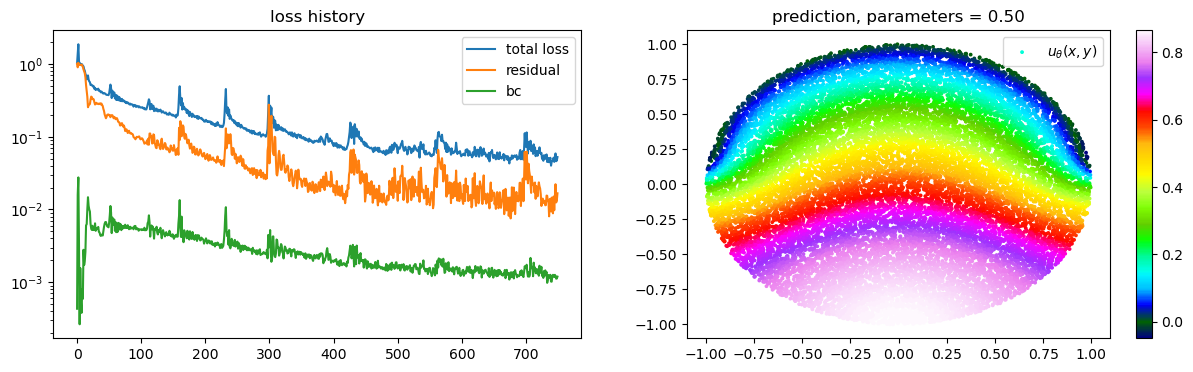

In [5]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [6]:
def get_param(i):
    parameter_domain = trainer.pde.parameter_domain.cpu().numpy()
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = []
        for k in range(len(parameter_domain)):
            param.append(np.random.uniform(parameter_domain[k][0], parameter_domain[k][1]))
    param = np.round(param, 2)
    return param

param = get_param(param_num)
print(param)
params = [param]

[0.5]


## Solution de référence

In [7]:
from dolfin import *
prm = parameters["krylov_solver"]
prm["absolute_tolerance"] = 1e-13
prm["relative_tolerance"] = 1e-13

In [10]:
import mshr

def create_ref_domain(deg,nb_vert=500,H=None):    
    # check if pb_considered is instance of Square class
    if isinstance(problem.geometry, Circle):
        center = problem.geometry.center
        radius = problem.geometry.radius
        box = np.array(problem.geometry.box)

        domain = mshr.Circle(df.Point(center[0],center[1]), radius)        
        mesh_macro = RectangleMesh(Point(box[0,0], box[1,0]), Point(box[0,1], box[1,1]), nb_vert, nb_vert)
        h_macro = mesh_macro.hmax()
        print("h_macro = ",h_macro)
        
        if H is None:
            # H = int(nb_vert*3/5)
            H = 700
        else:
            H = int(H)
        mesh_ref = mshr.generate_mesh(domain,H)
        h = mesh_ref.hmax()
        while h > h_macro:
            H += 1
            mesh_ref = mshr.generate_mesh(domain,H)
            h = mesh_ref.hmax()
            print("h : ",h)
    else:
        raise ValueError("Geometry not implemented")
    
    V_ref = df.FunctionSpace(mesh_ref, "CG", deg)
    print(V_ref.tabulate_dof_coordinates().shape)
    dx_ref = df.Measure("dx", domain=mesh_ref)
    
    h_ref = mesh_ref.hmax()
    print("hmax = ",h_ref)

    return mesh_ref, V_ref, dx_ref, H
    
def get_uref(param,deg,nb_vert=500,H=None):
    mesh_ref, V_ref, dx_ref, H = create_ref_domain(deg,nb_vert,H)
    
    f_expr = FExpr(param, degree=deg, domain=mesh_ref, pb_considered=problem)  
    
    def boundary_D(x,on_boundary):
        tol = 1e-6
        if on_boundary and x[1]>=0.0:
            if near(x[0],1.0,tol):
                print("oui : ",x)
            if near(x[0],-1.0,tol):
                print("oui : ",x)
        return on_boundary and x[1]>DOLFIN_EPS #and x[0]**2+x[1]**2>1.0-DOLFIN_EPS        
    g = Constant("0.0")
    bc = DirichletBC(V_ref, g, boundary_D)
    
    u = df.TrialFunction(V_ref)
    v = df.TestFunction(V_ref)
    
    # Resolution of the variationnal problem

    a = df.inner(df.grad(u),df.grad(v)) * dx_ref
    l = f_expr * v * dx_ref

    # solver = dol.KrylovSolver('cg', 'hypre_amg')
    # prm = solver.parameters
    # print(prm["absolute_tolerance"],prm["relative_tolerance"])
    # prm["absolute_tolerance"] = 1E-10
    # prm["relative_tolerance"] = 1E-10

    sol = df.Function(V_ref)
    # solver.solve(a==l, sol, bcs=bc)
    df.solve(a==l, sol, bcs=bc, solver_parameters={"linear_solver": "cg","preconditioner":"hypre_amg"})

    return sol,H


In [11]:
savedir = result_dir + "u_ref/"
create_tree(savedir)

nb_vert = 1000
deg_uref = 3

filename = f"u_ref_{param_num}_P{deg_uref}_N{nb_vert}_H*.npy"
pattern = os.path.join(savedir, filename)

import glob
matching_files = glob.glob(pattern)

load_ref = False
if not load_ref or not matching_files:
    print("Run")
    if matching_files:
        H = int(matching_files[0].split("_")[-1].split(".")[0][1:])
        u_ref,H = get_uref(param,deg=3,nb_vert=nb_vert,H=H)
    else:
        u_ref,H = get_uref(param,deg=3,nb_vert=nb_vert)
    vct_u_ref = u_ref.vector().get_local()
    filename = savedir + f"u_ref_{param_num}_P{deg_uref}_N{nb_vert}_H{H}.npy"
    np.save(filename, vct_u_ref)  
else:
    print("Load")
    vct_u_ref = np.load(matching_files[0])
    H = int(matching_files[0].split("_")[-1].split(".")[0][1:])
    mesh_ref, V_ref, dx_ref, _ = create_ref_domain(deg=deg_uref,nb_vert=nb_vert,H=H)
    u_ref = df.Function(V_ref)
    u_ref.vector()[:] = vct_u_ref

Run
h_macro =  0.0028284271247461927
h :  0.0028530652077421574
h :  0.0028489982598212233
h :  0.0028449433438386394
h :  0.0028409083995901904
h :  0.0028368752282765153
h :  0.002832860976016716
h :  0.00282885406315673
h :  0.0028248555169341264
(8907709, 2)
hmax =  0.0028248555169341264
  Solving linear variational problem.
oui :  [1. 0.]
oui :  [-1.0000000e+00  1.2246468e-16]


## Convergence FEM

In [14]:
def read_csv(testcase,param_num,degree):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    df_FEM = pd.read_csv(csv_file)
    tab_nb_vert_FEM = list(df_FEM['nb_vert'].values)
    tab_h_FEM = list(df_FEM['h'].values)
    tab_err_FEM = list(df_FEM['err'].values)
    
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

def run_FEM(degree,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = read_csv(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        print("Run FEM")
        tab_nb_vert_FEM = [2**i for i in range(4,9)]
        # tab_nb_vert_FEM = [2**i for i in range(4,8)]
        tab_h_FEM = []
        tab_err_FEM = []

        for nb_vert in tab_nb_vert_FEM:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            tab_h_FEM.append(solver.h)
            _,norme_L2 = solver.fem(0,u_ref)
            
            # colormap = "jet"
            # plt.figure()
            # c = df.plot(sol,cmap=colormap)
            # plt.colorbar(c)
            # plt.show()
            
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_FEM.append(norme_L2)
            
        df_FEM = pd.DataFrame({'nb_vert': tab_nb_vert_FEM, 'h': tab_h_FEM, 'err': tab_err_FEM})
        df_FEM.to_csv(csv_file, index=False)
            
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

In [15]:
degree = 1
df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(degree,new_run=True)

Run FEM
hmax =  0.1666302467485555
oui :  [1. 0.]
oui :  [-1.0000000e+00  1.2246468e-16]
nb_vert=16, norme_L2=0.04226436793395177
hmax =  0.08694671112404881
oui :  [1. 0.]
oui :  [-1.0000000e+00  1.2246468e-16]
nb_vert=32, norme_L2=0.020669775986768894
hmax =  0.043476071300047735
oui :  [1. 0.]
nb_vert=64, norme_L2=0.005881509939045604
hmax =  0.021977442177492472
oui :  [1. 0.]
oui :  [-1.0000000e+00  1.2246468e-16]
nb_vert=128, norme_L2=0.006668115853880523
hmax =  0.010988780934080039
oui :  [1. 0.]
oui :  [-1.0000000e+00  1.2246468e-16]
nb_vert=256, norme_L2=0.004197391470957118


degree=1
Read csv file ../../../results/testcase4/cvg/FEM_case4_param1_degree1.csv


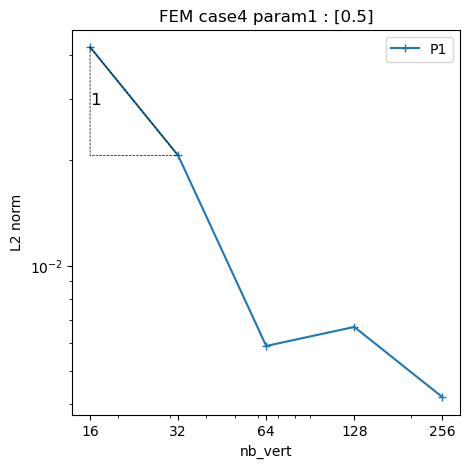

In [16]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
# for d in [1, 2, 3]:
for d in [1]:
    print(f"degree={d}")
    
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='P'+str(d))
    
    # add slope with a triangle
    start = [tab_nb_vert_FEM[1],tab_err_FEM[1]]
    end = [tab_nb_vert_FEM[0],tab_err_FEM[0]]
    third = [end[0],start[1]]
    
    tri_x = [end[0], third[0], start[0], end[0]]
    tri_y = [end[1], third[1], start[1], end[1]]
    plt.plot(tri_x, tri_y, "k--", linewidth=0.5)
    
    slope = (np.log(start[1])-np.log(end[1]))/(np.log(start[0])-np.log(end[0]))
    slope = abs(int(slope.round(0)))

    vert_mid = [(end[0]+third[0])/2., (end[1]+third[1])/2.]
    plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')
    
plt.xticks(df_FEM['nb_vert'], df_FEM['nb_vert'].round(3).astype(str))
plt.xlabel('nb_vert')
plt.ylabel('L2 norm')
plt.title(f'FEM case{testcase} param{param_num} : {param}')
plt.legend()
plt.savefig(result_dir+f'FEM_case{testcase}_param{param_num}.png')

In [31]:
dict = {}
for d in [1]: #, 2, 3]:
    print(f"degree={d}")
    _, tab_nb_vert_FEM, _, tab_err_FEM = run_FEM(d)
    if d == 1:
        dict['N'] = tab_nb_vert_FEM
    dict[f'P{d}'] = tab_err_FEM
    
df_deg = pd.DataFrame(dict)

csv_file = result_dir+f'FEM_case{testcase}_param{param_num}.csv'
df_deg.to_csv(csv_file, index=False)

degree=1
Read csv file ../../../results/testcase4/cvg/FEM_case4_param1_degree1.csv


## Convergence PINNs+Corr

In [32]:
def get_test_sample(solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    if shape[1] == 0:
        mu_test = torch.zeros(shape)
    else:
        ones = torch.ones(shape)
        mu_test = (torch.mean(trainer.pde.parameter_domain, axis=1) * ones)#.to(device)

    return V_test,X_test,mu_test

In [59]:
degree_PINNs = 10

def read_csv_Corr(testcase,param_num,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_Corr = list(df_Corr['nb_vert'].values)
    tab_h_Corr = list(df_Corr['h'].values)
    tab_err_Corr = list(df_Corr['err'].values)
    
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

def run_Corr(degree,new_run=False):
    csv_file = result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = read_csv_Corr(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        # tab_nb_vert_Corr = [2**i for i in range(4,9)]
        # tab_nb_vert_Corr = [2**i for i in range(4,7)]
        tab_nb_vert_Corr = [16]
        tab_h_Corr = []
        tab_err_Corr = []

        for nb_vert in tab_nb_vert_Corr:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            tab_h_Corr.append(solver.h)
            
            V_test,X_test,mu_test = get_test_sample(solver,trainer,degree_PINNs)
            pred = u_theta.setup_w_dict(X_test, mu_test)
            phi_tild = pred["w"][:,0].cpu().detach().numpy()
            
            u_PINNs = df.Function(V_test)
            u_PINNs.vector()[:] = phi_tild.copy()
            
            uref_Vex = interpolate(u_ref,solver.V_ex)
            sol_Vex = interpolate(u_PINNs,solver.V_ex)
            norme_L2_PINNs = (assemble((((uref_Vex - sol_Vex)) ** 2) * solver.dx) ** (0.5)) / (assemble((((uref_Vex)) ** 2) * solver.dx) ** (0.5))

            print(f"nb_vert={nb_vert}, norme_L2_PINNs={norme_L2_PINNs}")
            
            sol,C_tild,norme_L2 = solver.corr_add(0,u_PINNs,u_ref)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_Corr.append(norme_L2)
            
            
            
            
            #### PLOTT
            V_test_,X_test_,mu_test_ = get_test_sample(solver,trainer,degree)
            pred = u_theta.setup_w_dict(X_test_, mu_test_)
            phi_tild = pred["w"][:,0].cpu().detach().numpy()

            u_PINNs_1 = df.Function(V_test_)
            u_PINNs_1.vector()[:] = phi_tild.copy()

            C_ex = df.Function(solver.V)
            u_ex_inter = df.project(u_ref,solver.V)
            C_ex.vector()[:] = u_ex_inter.vector()[:] - u_PINNs_1.vector()[:]

            plt.figure(figsize=(15,10))

            plt.subplot(2,3,1)
            c = df.plot(C_ex)
            plt.colorbar(c)
            plt.title("C_ex")

            plt.subplot(2,3,2)
            c = df.plot(C_tild)
            plt.colorbar(c)
            plt.title("C_tild")

            plt.subplot(2,3,3)
            error = df.Function(solver.V)
            error.vector()[:] = C_ex.vector()[:] - C_tild.vector()[:]
            c = df.plot(error)
            plt.colorbar(c)
            plt.title("C_ex-C_tild")
            
            plt.subplot(2,3,4)
            c = df.plot(u_ex_inter)
            plt.colorbar(c)
            plt.title("u_ex")
            
            plt.subplot(2,3,5)
            sol_inter = df.project(sol,solver.V)
            c = df.plot(sol_inter)
            plt.colorbar(c)
            plt.title("sol")
            
            plt.subplot(2,3,6)
            error = df.Function(solver.V)
            error.vector()[:] = u_ex_inter.vector()[:] - sol_inter.vector()[:]
            c = df.plot(error)
            plt.colorbar(c)
            plt.title(f"u_ex-sol\nL2 norm : {norme_L2:.2e}")    

            # plt.suptitle("")

        # if filename is not None:
        #     plt.savefig(filename)
        # else:
        #     plt.show()
            
        df_Corr = pd.DataFrame({'nb_vert': tab_nb_vert_Corr, 'h': tab_h_Corr, 'err': tab_err_Corr})
        df_Corr.to_csv(csv_file, index=False)
            
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

hmax =  0.1666302467485555
nb_vert=16, norme_L2_PINNs=0.025269380446814337
nb_vert=16, norme_L2=0.09831552395293605


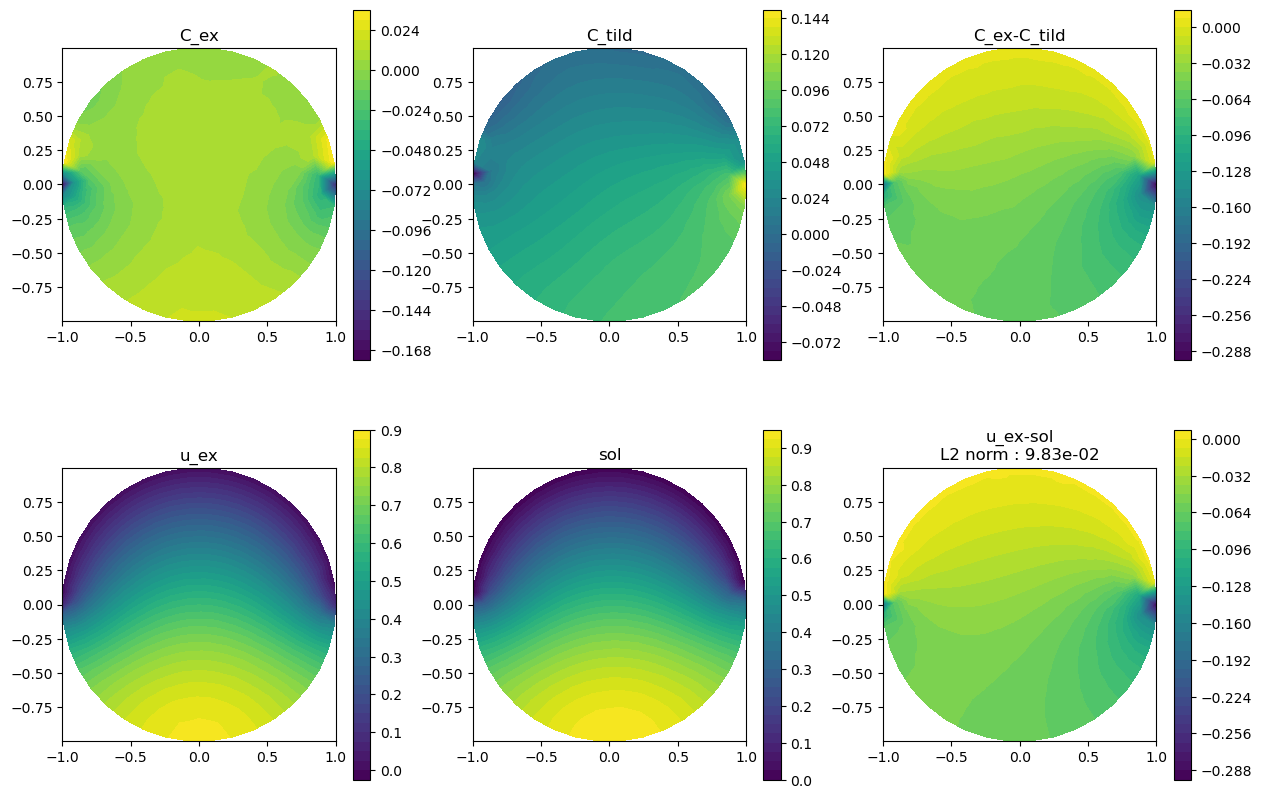

In [60]:
degree = 1
df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(degree,new_run=True)

degree=1
Read csv file ../../../results/testcase4/cvg/Corr_case4_param1_degree1.csv


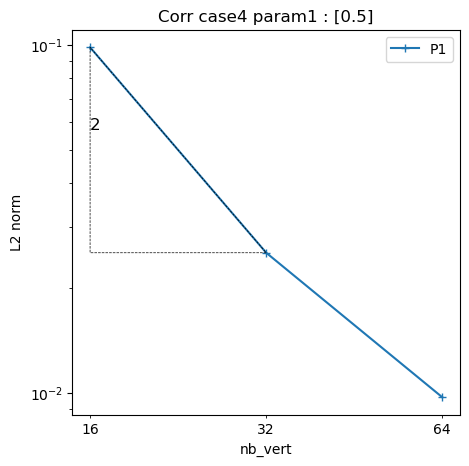

In [38]:
plt.figure(figsize=(5, 5))

# plot Corr error (L2 norm) as a function of h
# for d in [1, 2, 3]:
for d in [1]:
    print(f"degree={d}")
    df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['nb_vert'], df_Corr['err'], "+-", label='P'+str(d))
    
    # add slope with a triangle
    start = [tab_nb_vert_Corr[1],tab_err_Corr[1]]
    end = [tab_nb_vert_Corr[0],tab_err_Corr[0]]
    third = [end[0],start[1]]
    
    tri_x = [end[0], third[0], start[0], end[0]]
    tri_y = [end[1], third[1], start[1], end[1]]
    plt.plot(tri_x, tri_y, "k--", linewidth=0.5)
    
    slope = (np.log(start[1])-np.log(end[1]))/(np.log(start[0])-np.log(end[0]))
    slope = abs(int(slope.round(0)))

    vert_mid = [(end[0]+third[0])/2., (end[1]+third[1])/2.]
    plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=True)
plt.xlabel("nb_vert")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'Corr_case{testcase}_param{param_num}.png')

In [39]:
dict = {}
for d in [1]: #, 2, 3]:
    print(f"degree={d}")
    _, tab_nb_vert_Corr, _, tab_err_Corr = run_Corr(d)
    if d == 1:
        dict['N'] = tab_nb_vert_Corr
    dict[f'P{d}'] = tab_err_Corr
    
df_deg_Corr = pd.DataFrame(dict)

csv_file = result_dir+f'Corr_case{testcase}_param{param_num}.csv'
df_deg_Corr.to_csv(csv_file, index=False)

degree=1
Read csv file ../../../results/testcase4/cvg/Corr_case4_param1_degree1.csv


## Plots

degree=1
Read csv file ../../../results/testcase4/cvg/FEM_case4_param1_degree1.csv
degree=1
Read csv file ../../../results/testcase4/cvg/Corr_case4_param1_degree1.csv


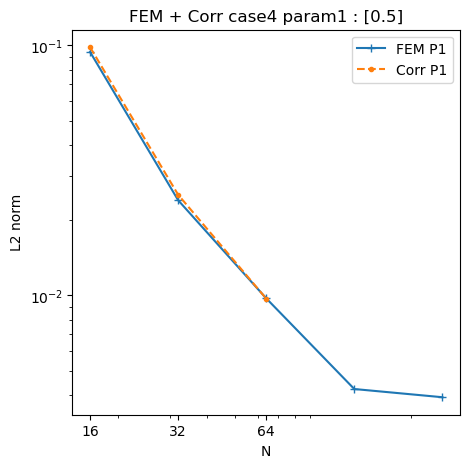

In [41]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
for d in [1]:#, 2, 3]:
    print(f"degree={d}")
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='FEM P'+str(d))

# plot Corr error (L2 norm) as a function of h
for d in [1]:#, 2, 3]:
    print(f"degree={d}")
    df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['nb_vert'], df_Corr['err'], ".--", label='Corr P'+str(d))

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=False)
plt.xlabel("N")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'FEM + Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'FEM-Corr_case{testcase}_param{param_num}.png')